<a href="https://colab.research.google.com/github/qhowery/COS324_PA4/blob/main/COS324_PA4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiclass Classification of Images using CNNs 

## Programming Assignment 4 (PA4)

In PA4, you will classify images of handwritten digits using CNNs. The dataset used is the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database).

**IMPORTANT**: Use Google CoLab for running your code. This should speed up your training time, which will make everything easier! **THIS NOTEBOOK IS VIEW ONLY. To copy it so you can edit, it, go to `File -> Save a Copy in Drive`**. 

**ENABLING GPU**: Simply upload the assignment notebook to your Google Drive, and open it with Google CoLab. Make sure to select GPU in the settings for CoLab. This can be done by going to 

`runtime->change runtime type->Hardware Accelerator->GPU`

The notebook is broken into the following sections:
1. Loading MNIST (no ACT's)
2. Building the CNN
3. Building the Trainer
4. Training the Network
5. Network Accuracy
6. Visualizing CNN Layers
7. Comparing with a Fully Connected Network

### New Python concepts
In addition to Python concepts seen so far, this assignment requires the following **new** knowledge:
- Classes
  - *Stanford CS231n Python Numpy Tutorial*: "Classes" section [[link](https://cs231n.github.io/python-numpy-tutorial/#classes)]
  - *Harvard CS181 Code Crash Course*: Sec 8.0.4 on "Defining and Creating Instances of Classes" [[link](https://harvard-ml-courses.github.io/cs181-web/sections/sec0_CS181_Code_Crash_Course.pdf)]

If you're new to Python, we recommend you briefly learn the basics of the above before starting the assignment.

### General Hints
- See precept materials for more details on how to use PyTorch modules.
- Read all the code in a cell first and understand its structure before filling in code statements for that cell.

### A Note on GPU Runtime
For this assignment, we encourage you to use GPU run time for ACT 16 (Training the network) onwards. By using a GPU, the code related to training and evaluating your `ConvNet` network will execute much more quickly.

By using a Colab notebook, you have 12 hours of access to a GPU (as mentioned in the Google Colab [FAQ](https://research.google.com/colaboratory/faq.html) section).

To conserve as much GPU run time as possible for ACT 16 onwards, we encourage you to complete ACT 1-15 with the `Hardware Accelerator` set to `None`.

Before starting ACT 16, we then encourage you to set `Hardware Accelerator` to `GPU`. Then, re-run ACT 1-15 before starting on ACT 16, as changing the `Hardware Accelerator` will reset the notebook runtime.

The `Hardware Accelerator` option can be found by clicking the `Edit` tab, then `Notebook settings`.

With that said, if you have run out of GPU run time, the assignment can still be completed without it. The following sections will likely take longer to execute (seconds versus seconds).

Please budget your GPU run time accordingly, as no extensions or late exceptions will be made due to GPU access issues. 

In [ ]:
!pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4147 sha256=bf3a40dc365ad02c5802ab832c14d98f27d867ade9cdf99a47cbb5c37bfc6cc6
  Stored in directory: /root/.cache/pip/wheels/29/65/6e/db2515eb1dc760fecd36b40d54df65c1e18534013f1c037e2e
Successfully built torchviz


In [ ]:
# Setting some hyperparameters and making sure we have a GPU
%matplotlib inline
import numpy as np 
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import random
from torchviz import make_dot

# Set the device to use
device = torch.device("cpu")

# We encourage you to complete ACT 1-15 using a CPU, then switching to GPU upon beginning ACT 16
# If you'd like to use a GPU instead of a CPU to run the following code, you can uncomment the following line
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Hyperparameters
num_epochs = 10
num_classes = 10  # there are 10 digits: 0 to 9
batch_size = 256

## Fixing Random Seed for Reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)


# This line prints out the type of device you will run the notebook in.
print(str(device))

cpu


### Loading MNIST
Here we are loading the MNIST dataset. This dataset consists of 60,000 training images and 10,000 test images.

Each image is a 28-by-28 grayscale image, so it is represented by a 28-by-28 array. The labels are 0 to 9, representing digits 0-9.

In [ ]:
from torch.utils.data import DataLoader

# transforms to apply to the data, converting the data to PyTorch tensors and normalizing the data
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=trans)

# train_loader returns batches of training data. See how train_loader is used in the Trainer class later
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True,num_workers=0)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False,num_workers=0)

##ASSERTS: checking whether the data is loaded as expected
assert(len(train_loader)*batch_size >= 60000)
assert(len(test_loader)*batch_size >=10000)

100%|██████████| 9912422/9912422 [00:00<00:00, 304731307.77it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 24063506.92it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 149471382.49it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 6684396.06it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Building the network
Let's build a CNN to classify MNIST images. You will build a CNN with the following architecture:

Input:
0. The input is a 28-by-28 image with only 1 channel (since it is grayscale)

Network:
1.   `conv1`: 2D Convolutional Layer with 32 output channels, 5-by-5 kernels, and padding of size 2, activation function RELU
2.   `pool1`: Max Pooling with a 2-by-2 kernel and a stride of size 2
3.   `conv2`: 2D Convolutional Layer with 64 output channels, 5-by-5 kernels, and padding of size 2, activation function RELU
4.   `pool2`: Max Pooling with a 2-by-2 kernel and a stride of size 2
5.   `fc1`: Fully Connected Layer with output size 512 with RELU activation
6.   `fc2`: Fully Connected Layer with output of size 10 (no activation function)

ACTS 1-9 require you to fill in the blank code statements in the cell below.

**Hint:** See `torch.nn` [documentation](https://pytorch.org/docs/stable/nn.html).

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


### ACT1-ACT9:
### Complete the code below based on the architecture described above
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, 1, 2) #ACT1
        self.pool1 = nn.MaxPool2d(2, 2) #ACT2
        self.conv2 = nn.Conv2d(32, 64, 5, 1, 2) #ACT3
        self.pool2 = nn.MaxPool2d(2, 2) #ACT4

        # ACT5 compute the size of the the input for the first fully connected layer.
        # You can track what happens to a 28-by-28 image when passes through the previous layers.
        # You will endup with 64 channels, each of size x-by-x, 
        # therefore the size of input is (64*x*x) - you need to compute x and fill the code below
        self.size_linear = (64 * 7 * 7)#ACT5
        self.fc1 = nn.Linear(self.size_linear, 512)
        self.fc2 = nn.Linear(512, 10)#ACT6
    
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x))) # we provide this line for you
        x = self.pool2(F.relu(self.conv2(x)))# ACT7: apply the second convolution and max pooling
        x = x.view(-1, self.size_linear) # this flattens x into a 1D vector
        x = F. relu(self.fc1(x)) # ACT8: Apply the first fully connected layer and ReLU
        x = self.fc2(x) # ACT9: Apply the second fully connected layer (no ReLU)
        return x
    
##ASSERT: checks if your CNN has the correct output shape
with torch.no_grad():  # tells PyTorch not to track gradients here
    # test_data is 100 random images, 1 channel, 28-by-28
    test_data = torch.rand(100,1,28,28)
    test_net = ConvNet()
    out = test_net.forward(test_data)
    # the output should have size (100,10)
    assert(out.size()==(100,10))


### Visualize Your Network

**ACT10**

Use the `made_dot()` function from `torchvis` to visualize your network. Check https://github.com/szagoruyko/pytorchviz#usage for more details.

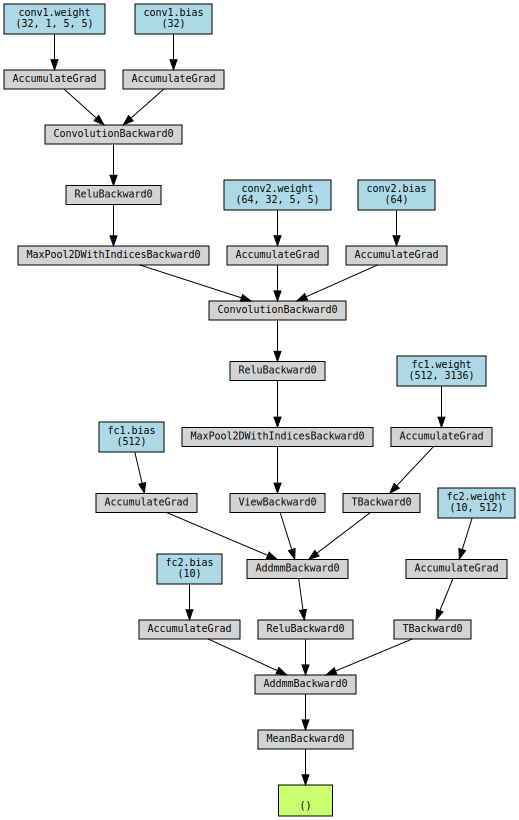

In [ ]:
from IPython.display import Image

test_data = torch.rand(100,1,28,28)
test_net = ConvNet()
out = test_net.forward(test_data)
make_dot(out.mean(), params=dict(test_net.named_parameters()))  # ACT10

### Building the trainer
To train our model, we'll build a Trainer class that holds our network and data. When we call 

```
trainer.train(epochs)
```
The Trainer trains over all the data for *epochs* times. It iterates over batches of data from the train_loader, passes it through the network, computes the loss and the gradients and lets the optimizer (SGD in this case) update the parameters.

Look at the cell below to see how we instantiate a trainer, and complete the Trainer code via the ACT's.

**Hints:** 
- See `torch.optim` [documentation](https://pytorch.org/docs/stable/optim.html).
- Scroll to the next code cell to see what `loss_function` is set to and look at [documentation](https://pytorch.org/docs/stable/nn.html#loss-functions) for it.

In [ ]:
### ACT11-ACT15 Please fill the code below
class Trainer():
    def __init__(self,net=None,optim=None,loss_function=None, train_loader=None):
        self.net = net
        self.optim = optim
        self.loss_function = loss_function
        self.train_loader = train_loader

    def train(self,epochs):
        losses = []
        for epoch in range(epochs):
            epoch_loss = 0.0
            epoch_steps = 0
            for data in self.train_loader:
                
                # Moving this batch to GPU
                # Note that X has shape (batch_size, number of channels, height, width)
                # which is equal to (256,1,28,28) since our default batch_size = 256 and 
                # the image has only 1 channel
                X = data[0].to(device)
                y = data[1].to(device)
                
                # ACT11-Zero the gradient in the optimizer i.e. self.optim
                ################
                self.optim.zero_grad()
                ################

                # ACT12-Getting the output of the Network
                ################
                output = self.net(X)
                ################

                # ACT13-Computing loss using loss function i.e. self.loss_function
                ################
                loss = loss_function(output, y)
                ################

                # ACT14-Backpropagate to compute gradients of parameteres
                ################
                loss.backward()
                ################

                # ACT15-Call the optimizer i.e. self.optim
                ################
                self.optim.step()
                ################

                epoch_loss += loss.item()
                epoch_steps += 1
            # average loss of epoch
            losses.append(epoch_loss / epoch_steps)
            print("epoch [%d]: loss %.3f" % (epoch+1, losses[-1]))
        return losses

### Training the network 
Let's find the right learning rate. Test out training using various learning rates (you'll want to reinitialize the network each time you choose a new learning rate).

Your task is to find a learning rate that results in less than 0.03 loss after 10 epochs of training. When submitting the notebook, submit it with that learning rate value filled in for ACT16.

**NOTE**: At this point, if you have been running the notebook using `CPU` (i.e. with `Hardware Accelerator` set to `None`), we now encourage you to change the setting to `GPU` and re-run the notebook up to this point. Going forwards, your code will execute much more quickly if a GPU is enabled.

In [ ]:
import torch.optim as optim

### ACT16 try different learning rates for SGD to see which one works (do not try learning rates greater than 1)
### number of epochs is fixed at 10, do not change it
### we want the last epoch loss to be less than 0.03
learning_rate = 0.01

net = ConvNet()
net = net.to(device)
opt = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
loss_function = nn.CrossEntropyLoss()

trainer = Trainer(net=net, optim=opt, loss_function=loss_function, train_loader=train_loader)

losses = trainer.train(num_epochs)
###ASSERTS
assert(losses[-1] < 0.03)
assert(len(losses)==num_epochs)  # because you record the loss after each epoch

epoch [1]: loss 0.367
epoch [2]: loss 0.075
epoch [3]: loss 0.053
epoch [4]: loss 0.040
epoch [5]: loss 0.033
epoch [6]: loss 0.028
epoch [7]: loss 0.024
epoch [8]: loss 0.021
epoch [9]: loss 0.017
epoch [10]: loss 0.016


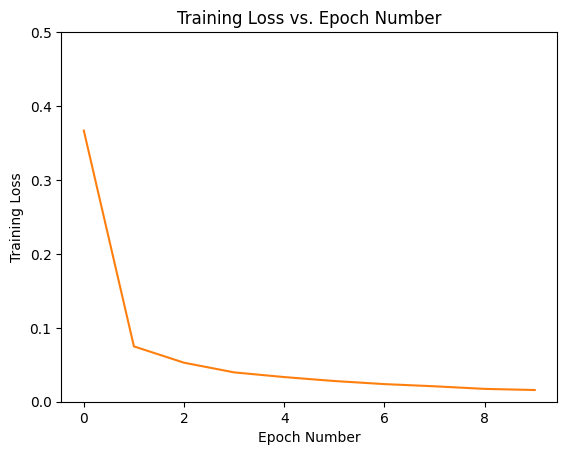

In [ ]:
import matplotlib.pyplot as plt
### ACT17 plot the training loss (y-axis) vs epoch number (x-axis)
### using the losses you computed in previous step
### ACT17 ######
plt.title("Training Loss vs. Epoch Number")
plt.ylabel("Training Loss")
plt.xlabel("Epoch Number")
ax = plt.gca()
ax.set_ylim([0, 0.5])
plt.plot(num_epochs)
plt.plot(losses)
################

### Accuracy of our network on test data
In this cell you will compute the accuracy of your network on the test data. If your CNN is working correctly, you should get accuracy of >98% on the test data.

In [ ]:
err = 0
tot = 0
with torch.no_grad():
    for data in test_loader:
        # ACT18: retrieve X and y for this batch, from data, and 
        #   move it to the device you are using (probably the GPU)
        #   (hint: look at what we did in trainer)
        X = data[0].to(device)
        y = data[1].to(device)

        # raw output of network for X
        output = net(X)
        
        # let the maximum index be our predicted class
        _, yh = torch.max(output, 1) 

        # tot will 10,000 at the end, total number of test data
        tot += y.size(0)

        ## ACT19 add to err number of missclassification, i.e. number of indices that 
        ## yh and y are not equal
        ## note that y and yh are vectors of size = batch_size = (256 in our case)
        err += not torch.equal(y, yh)

print('Accuracy of prediction on test digits: %5.2f%%' % (100-100 * err / tot))

###ASSERTS
assert((100-100 * err / tot)>=98)
assert(tot==10*1000)

Accuracy of prediction on test digits: 99.71%


### Inspecting Model Errors
**ACT 20** 

**Briefly describe what you observe when the model makes incorrect predictions. Is the model making obvious mistakes? Or is the data also tricky?**

**ANSWER HERE**: The data is tricky, there is some ambiguity between how some of the numbers are written. There are similarities between how some are written, like comparing 4 with 9 and 6 with 0 are some examples. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

### function for normalizing a 2d image (input type = numpy 2d array)
def normalize_image(npimg):
    npimg = (npimg - np.mean(npimg)) / np.std(npimg)
    npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
    return npimg

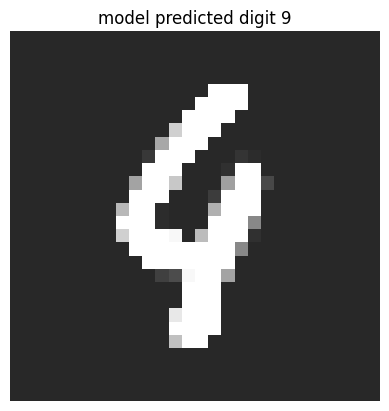

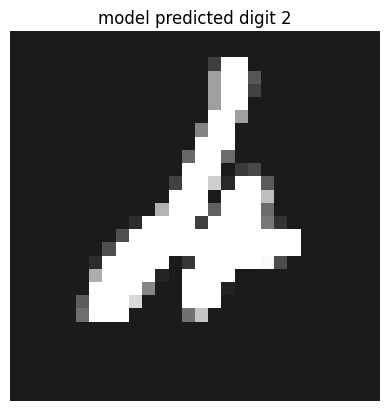

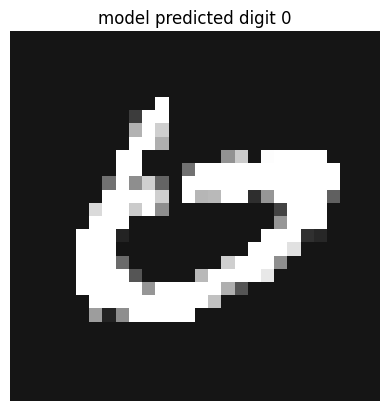

In [ ]:
num_to_check = 3 # inspect 3 examples
num_checked = 0
test_loader_for_error_analysis = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False, num_workers=0)
net.eval()
with torch.no_grad():
    for data in test_loader_for_error_analysis:
        # ACT18 retrieve X and y for this batch from data and 
        # move it to GPU (hint: look at what we did in trainer)
        X = data[0].to(device)
        y = data[1].to(device)

        # raw output of network for X
        output = net(X)
        
        # let the maximum index be our predicted class
        _, yh = torch.max(output, 1)
        
        # check incorrect prediction
        if yh.item() != y.item():
            plt.figure()
            npimg = X[0][0].to('cpu').numpy()
            npimg = normalize_image(npimg)
            plt.imshow(npimg,cmap="gray",vmin=0,vmax=1)
            plt.title("model predicted digit %d" % yh.item())
            plt.axis("off")
            num_checked += 1
            if num_checked == num_to_check:
                break

### Visualize CNN layers
Now you will visualize some internal values in the CNN. You will visualize the filters in the CNN and the result of applying those CNN filters to input images.

#### Visualize each filter separately in the first layer

* Our first layer was a 2d convolutional layer with 32 output channels and 5-by-5 kernel
* Therefore we have 32 different learnt filters. Each has size (1,5,5), so, each filter is a 5-by-5 array of weights
* Let's look at each filter as a 5-by-5 grayscale image and plot it

After running this cell, answer the following question:


**ACT21:**
Note we decided to fill in the code for you for `npimg`. However, make sure to understand what it is doing. 
**Briefly explain what are these filters detecting. One to two sentences should be sufficient.**

**ANSWER HERE**: The filters are detecting the most identifiable features like outstanding shapes and lines. It reorganizes the image into different groupings of pixels that would help to distinguish its main characteristics. 


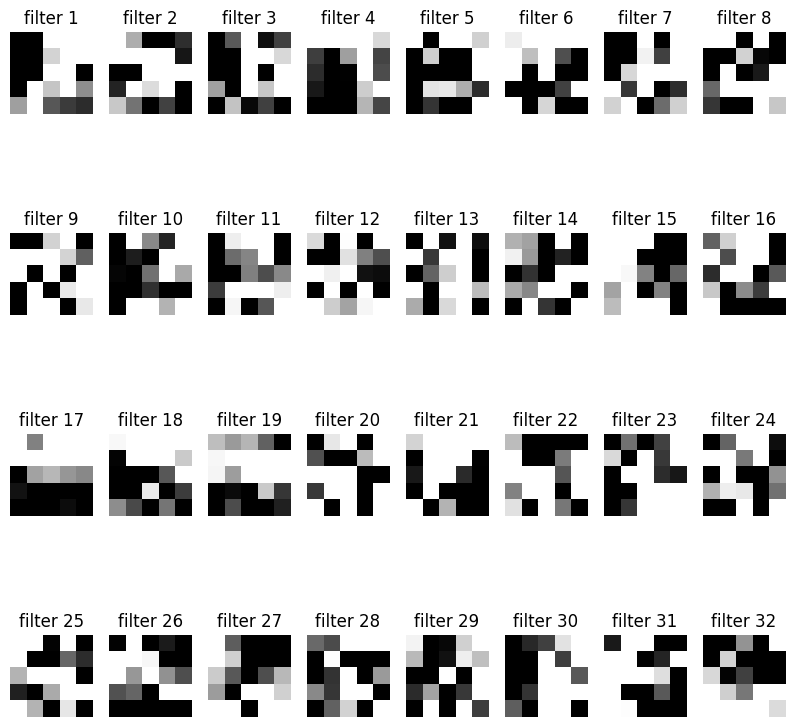

In [ ]:
### ACT21:
### fill in the line of code below
### hint: start by looking the shape/size of net.conv1.weight 
#print(net.conv1.weight.size())

plt.figure(figsize=(10,10))
for i in range(32):
    plt.subplot(4,8,i+1)
    npimg = net.conv1.weight.detach().cpu().numpy()[i, 0] #ACT21
    # npimg is a 5-by-5 numpy array corresponding to the i-th filter
    # if you need to move npimg off the GPU, you can use .cpu()
    # you should convert from PyTorch to Numpy in ACT21
    npimg = normalize_image(npimg)
    plt.imshow(npimg,cmap="gray",vmin=0,vmax=1)
    plt.title("filter "+str(i+1))
    plt.axis("off")
plt.show()

### Visualize the input after applying the first layer

*  First layer has 32 filters
*  Since padding is 2 and kernel is 5-by-5, each output channel will be again 28-by-28
*  Let's visualize each of these 32 pictures for one example of each digit

**ACT22**
**Fill in the code and describe what these images are. (Hint term defined in lecture)** 

**ANSWER HERE:** The images show the result of appling each filter for each digit. 

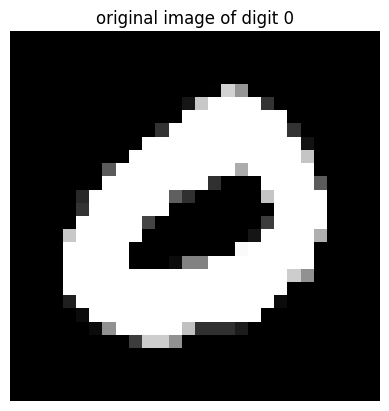

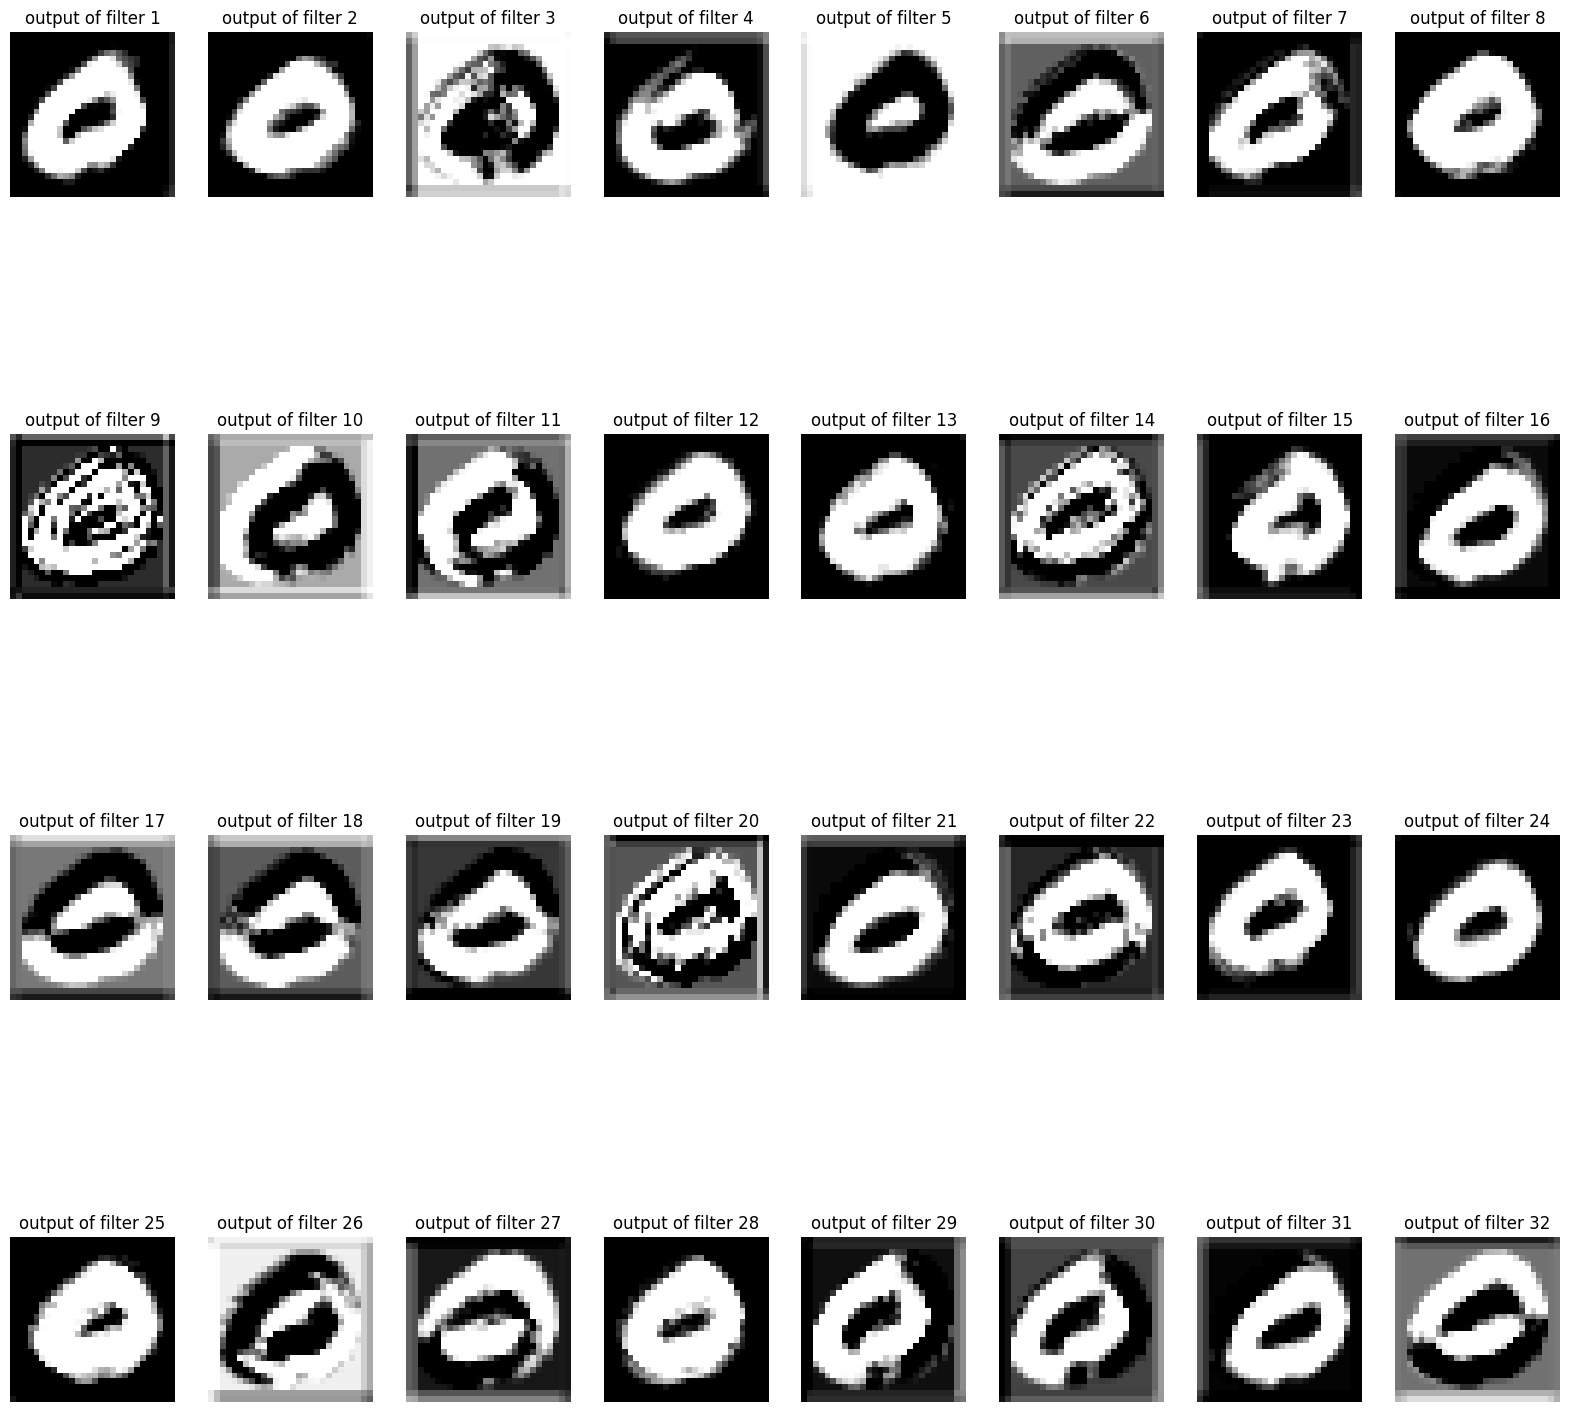

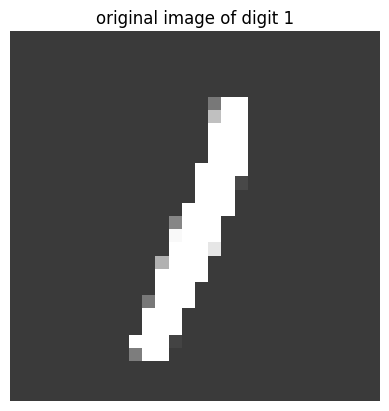

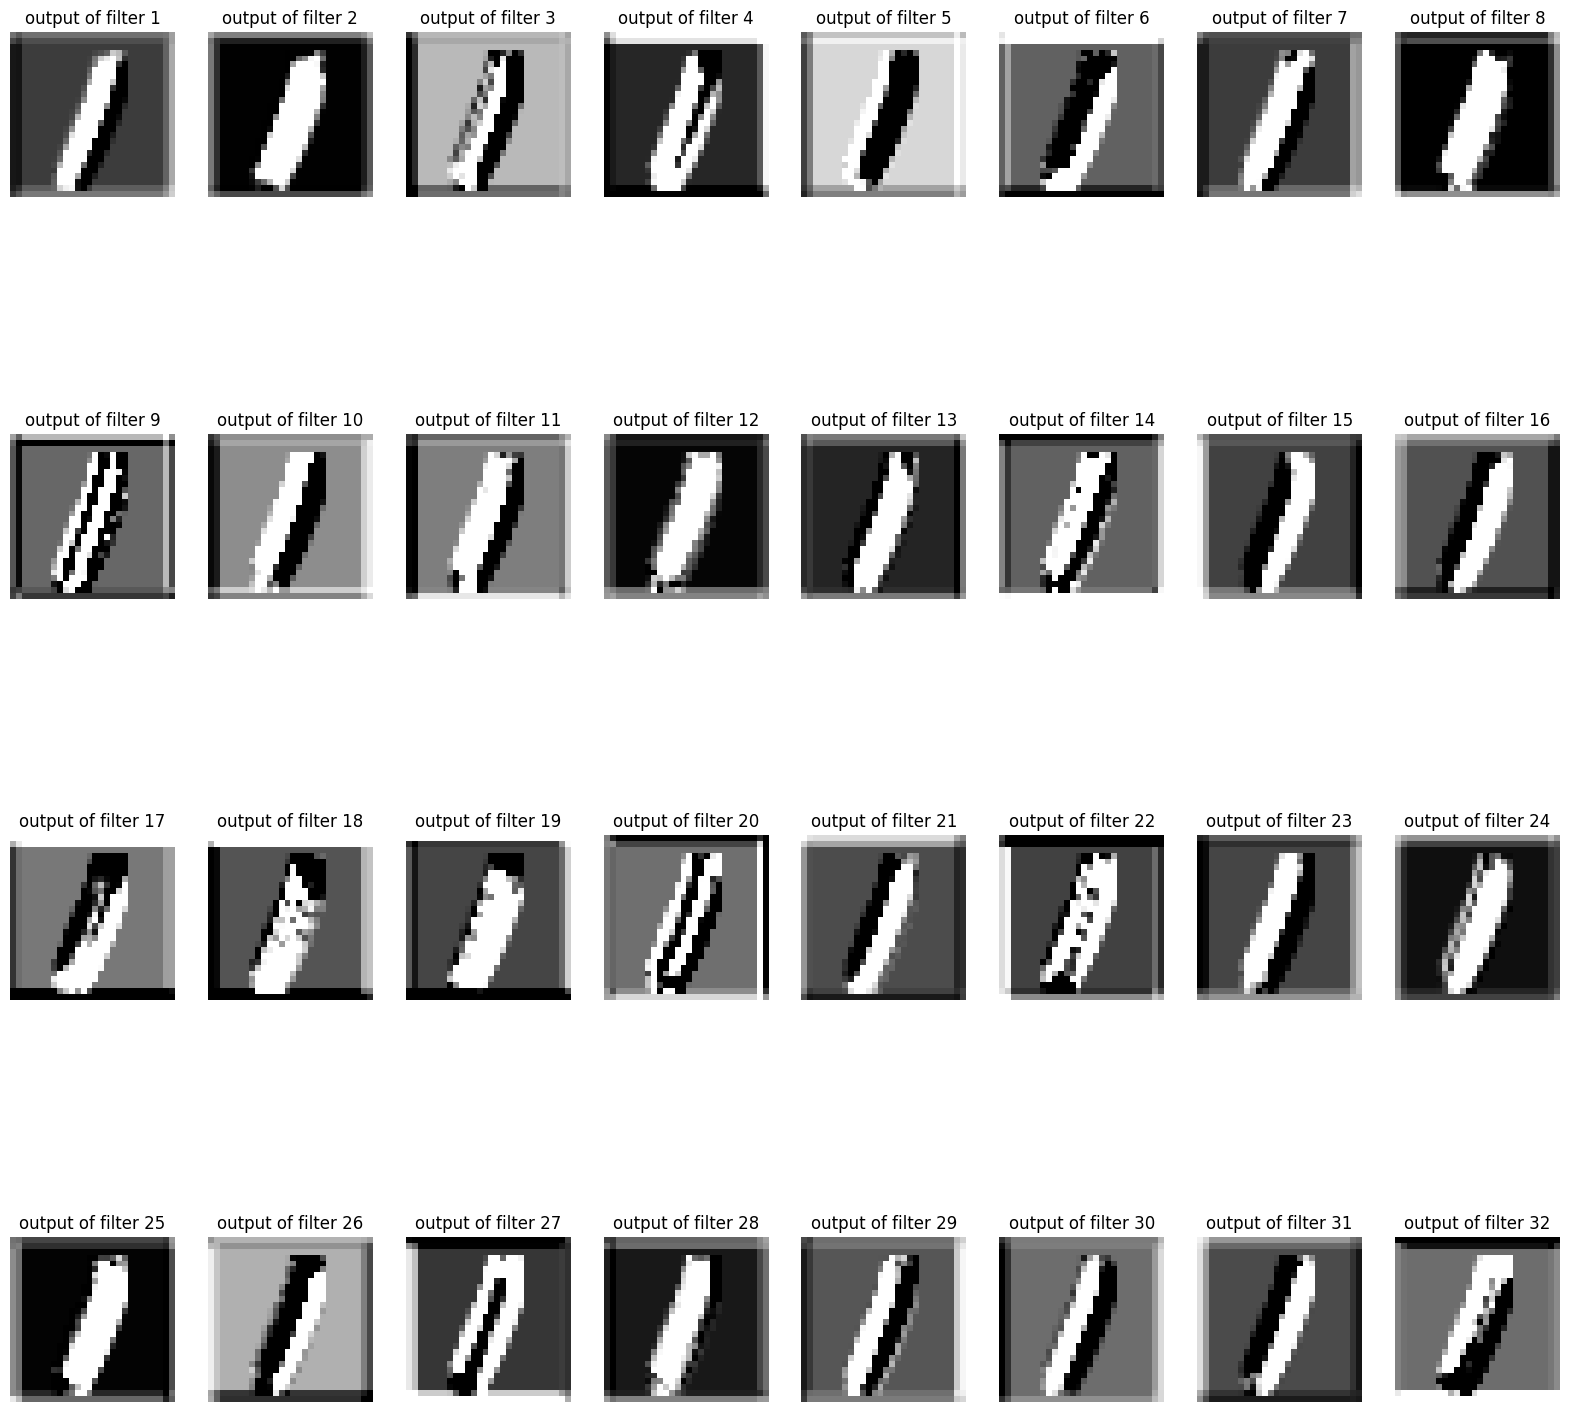

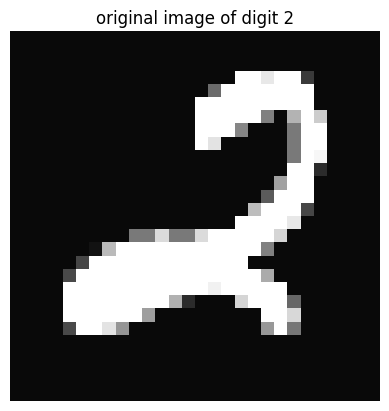

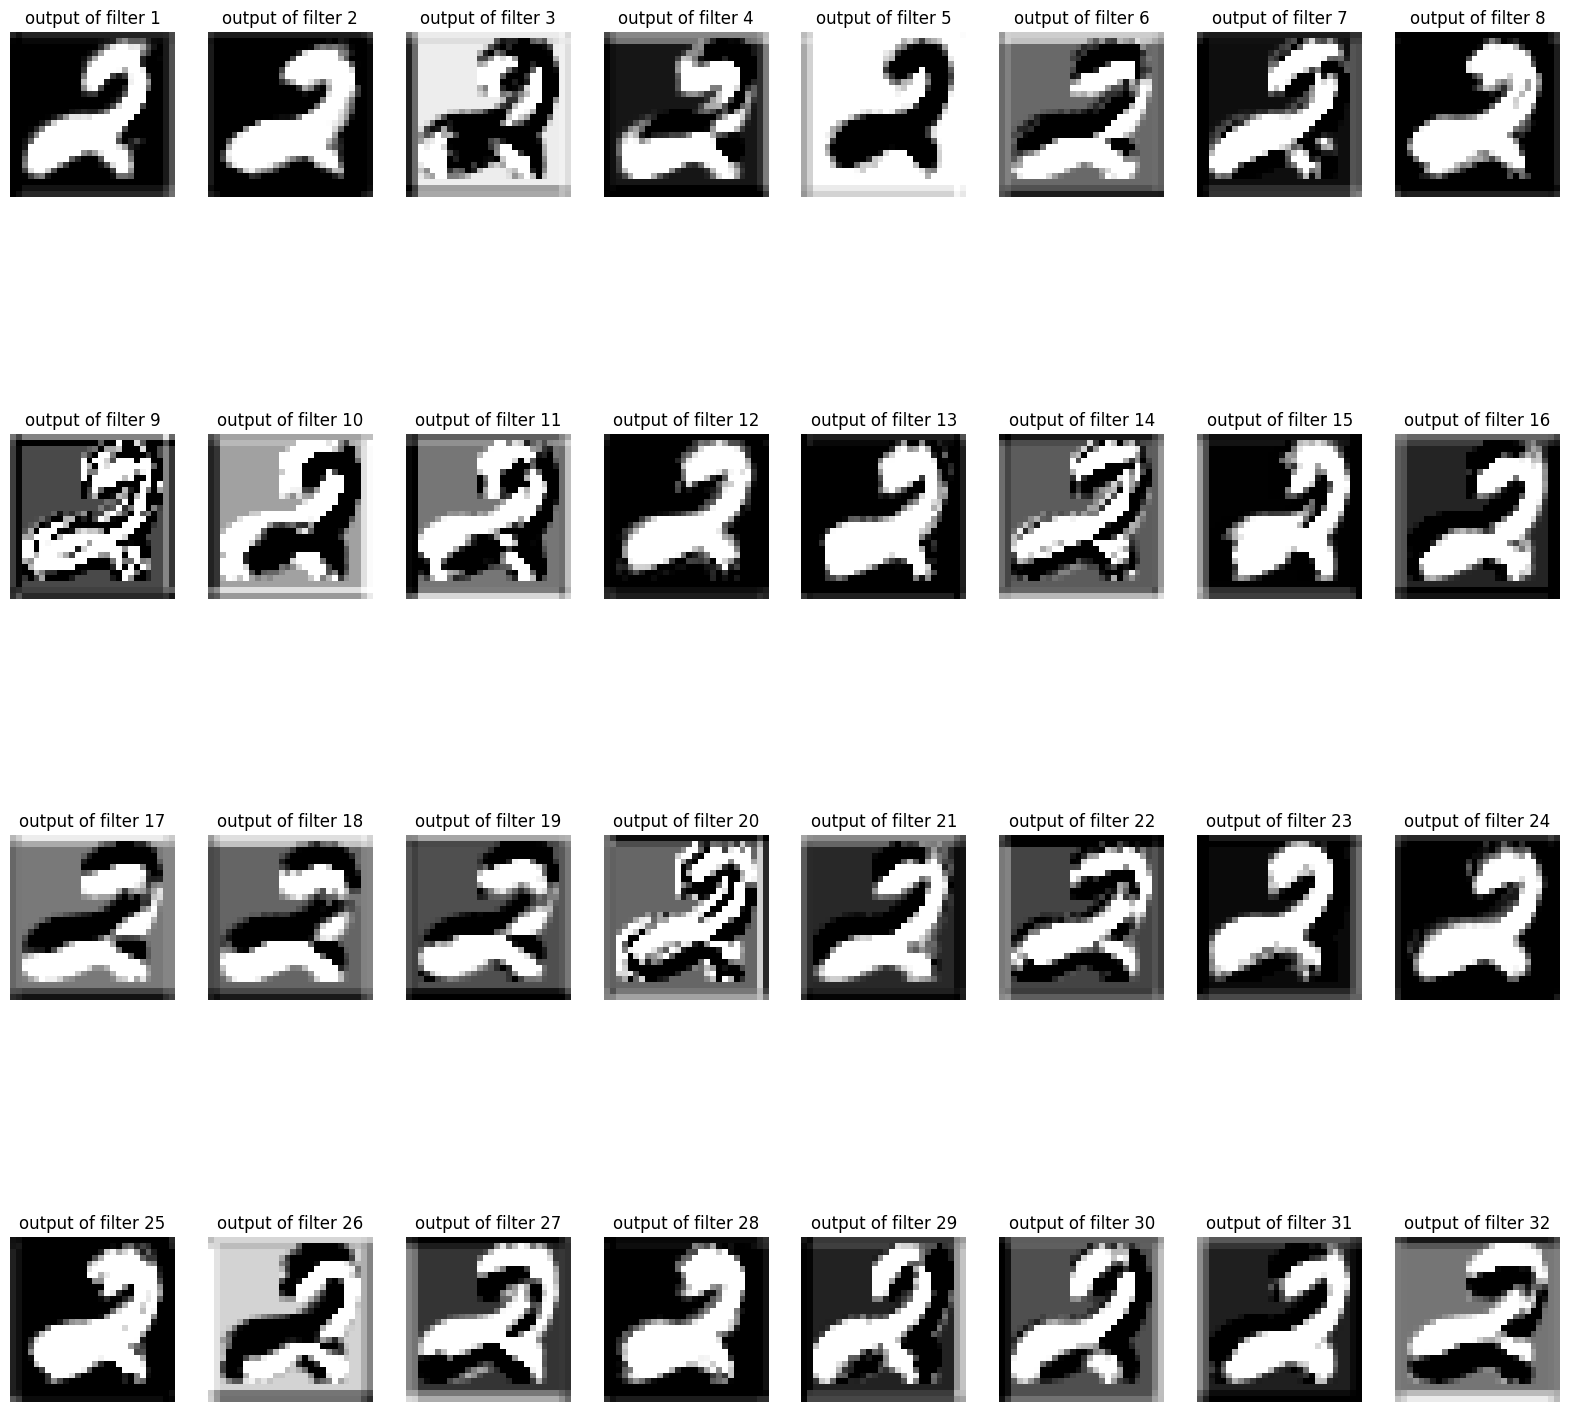

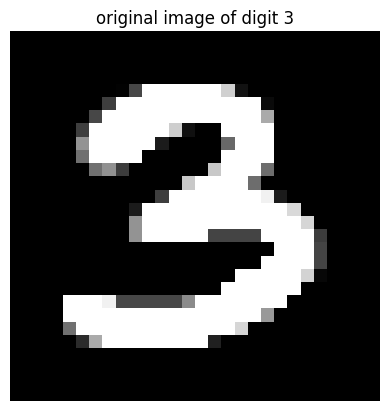

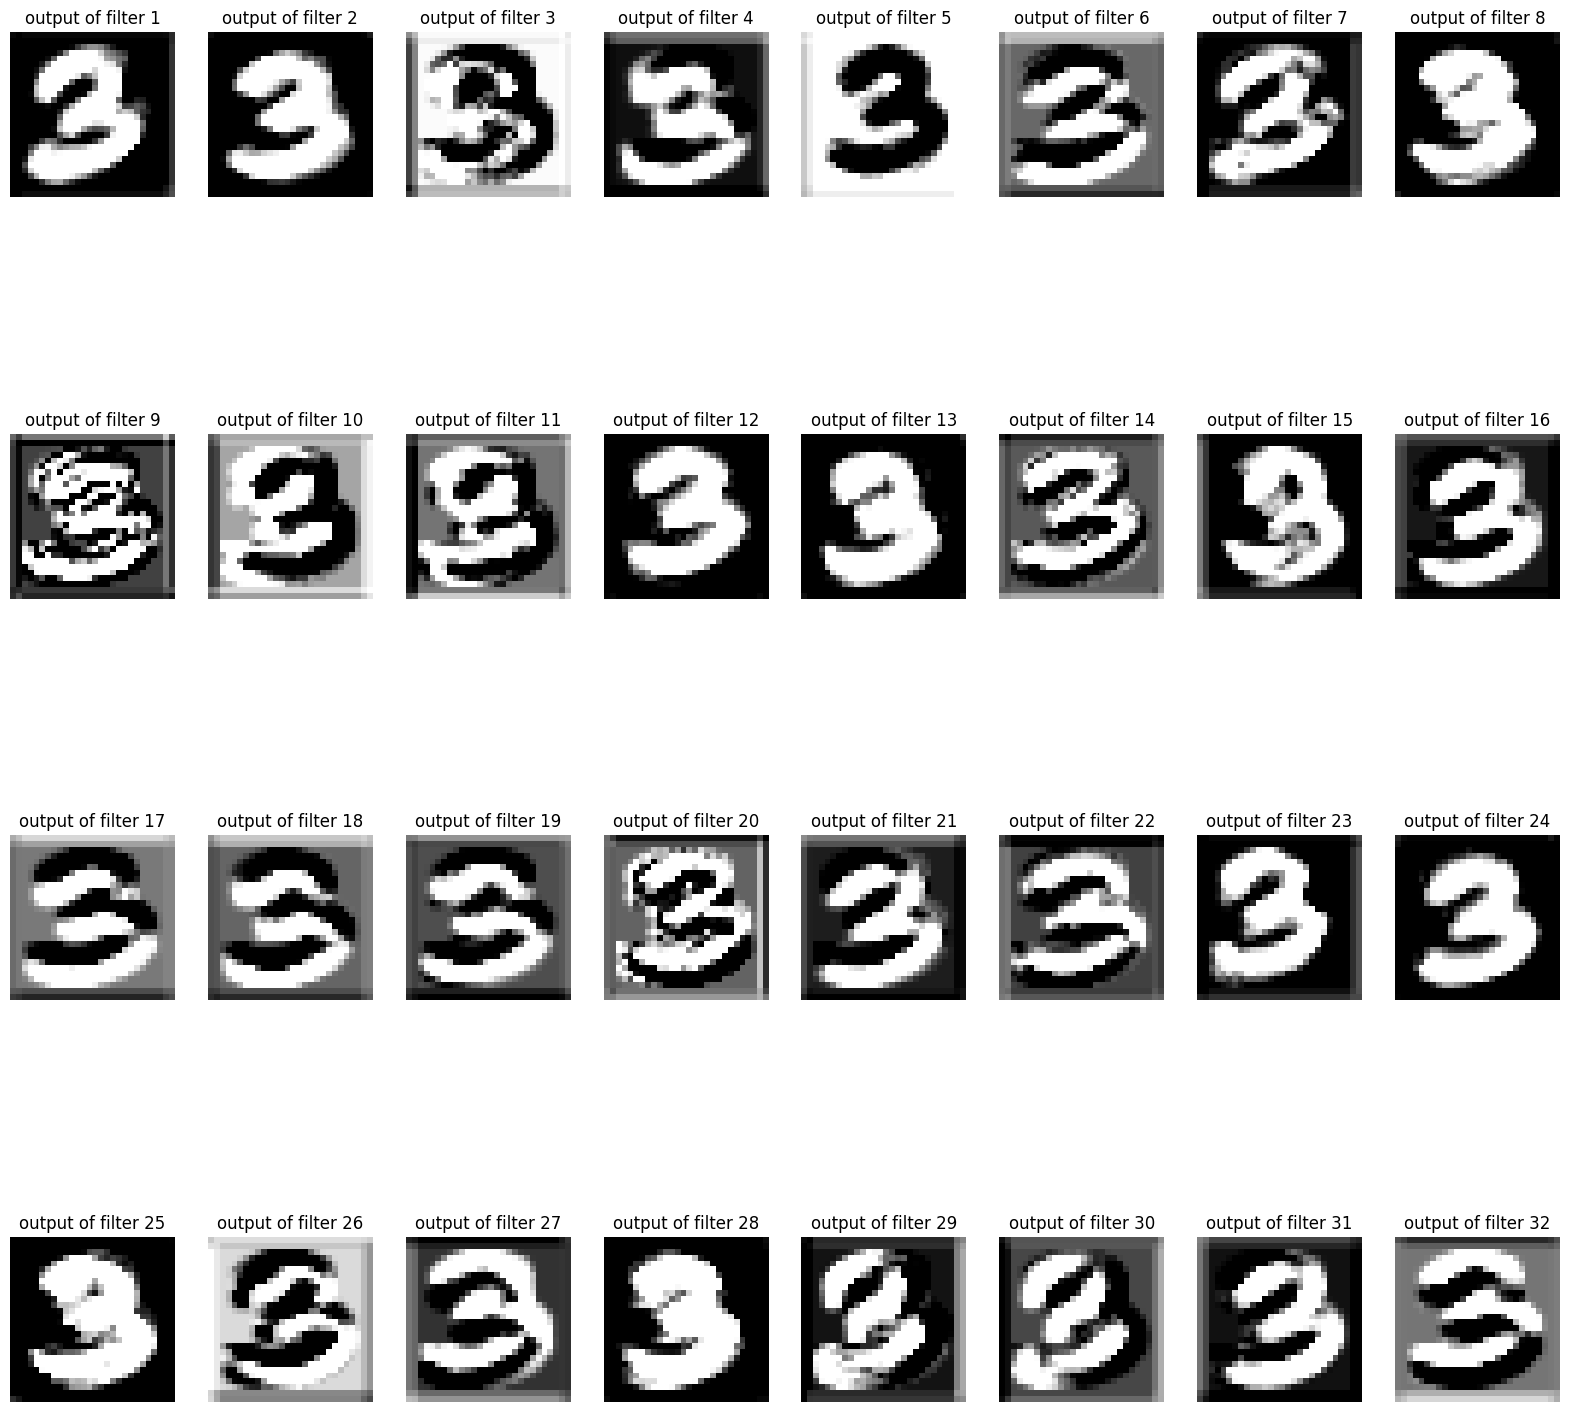

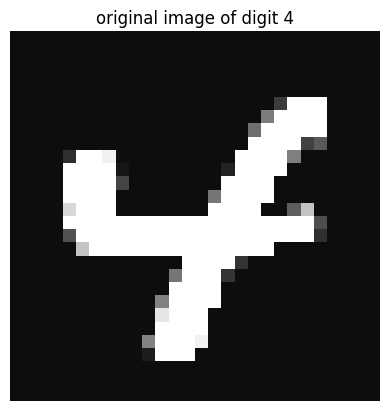

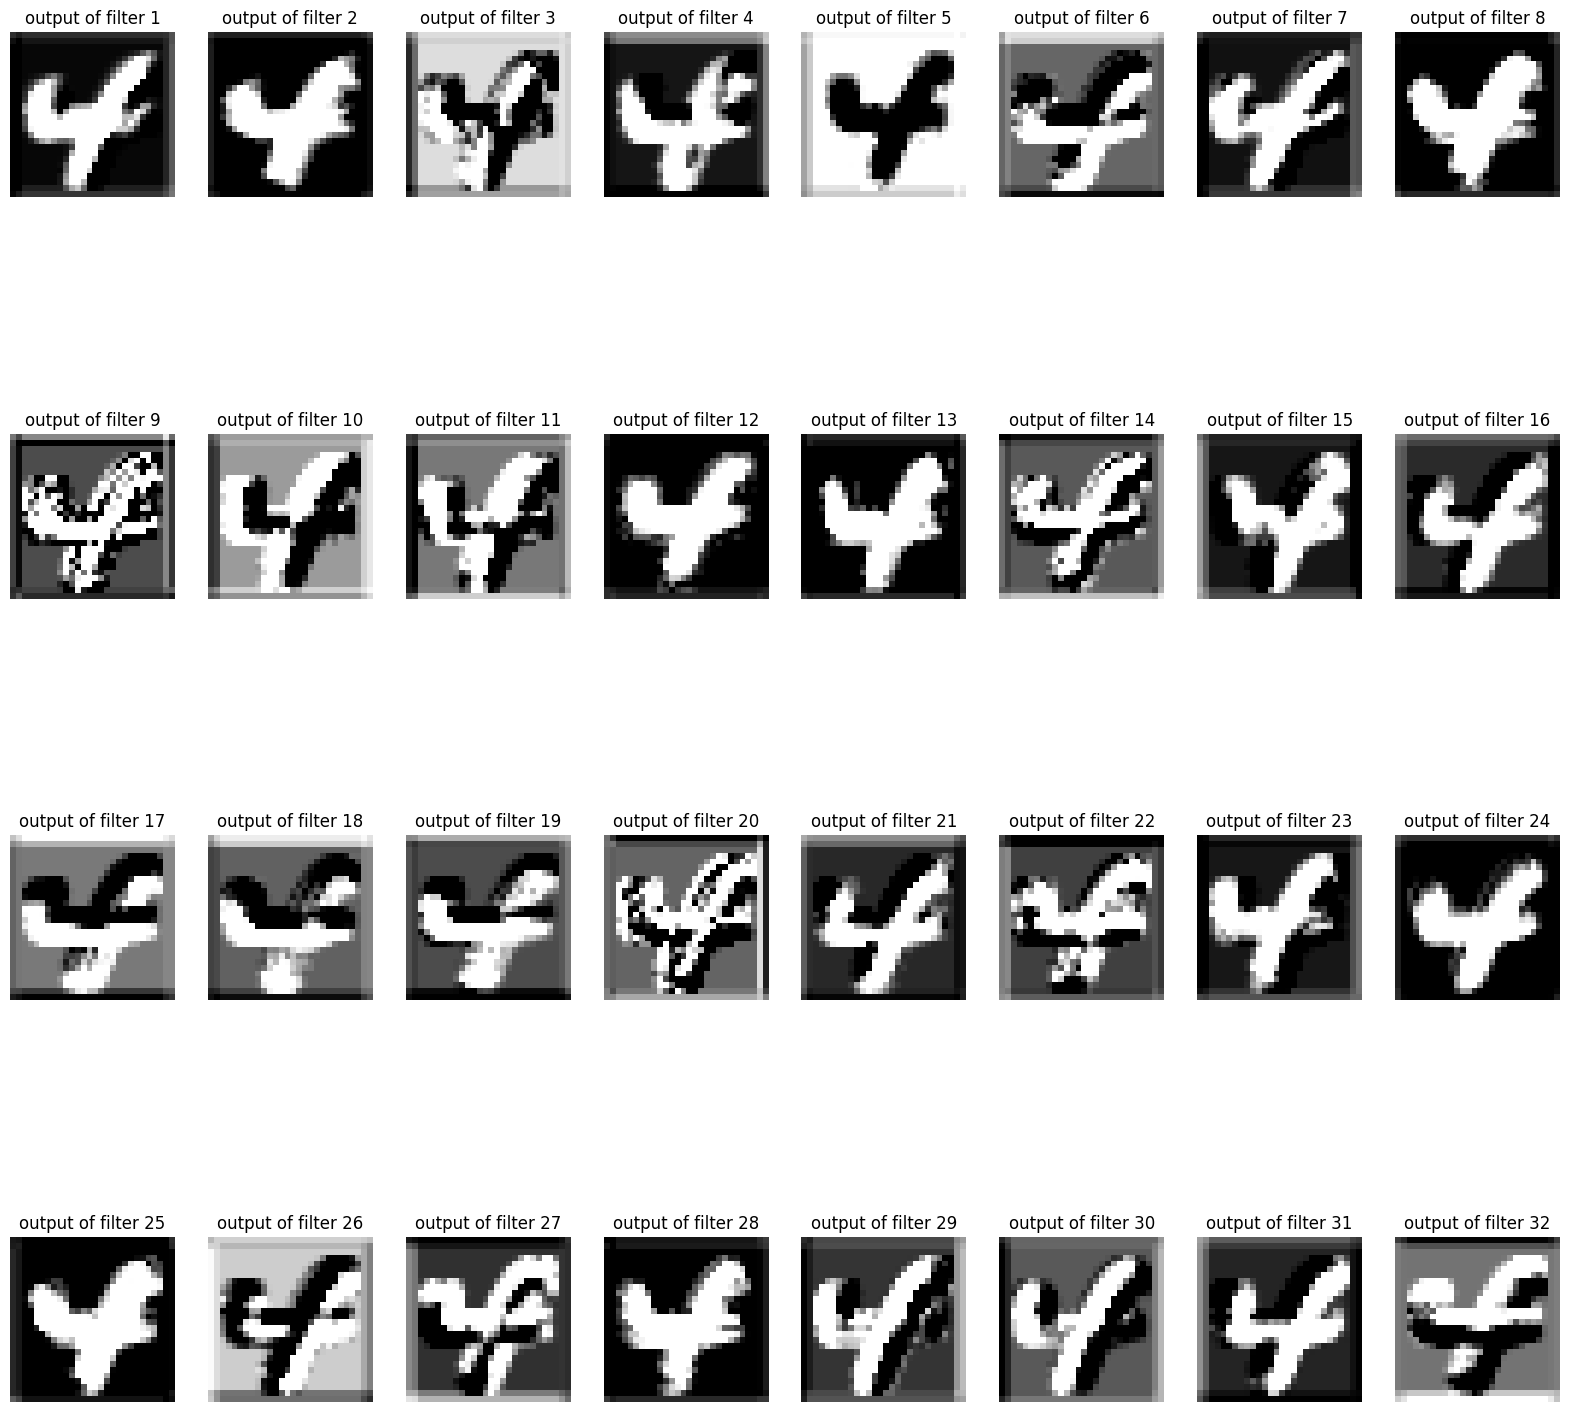

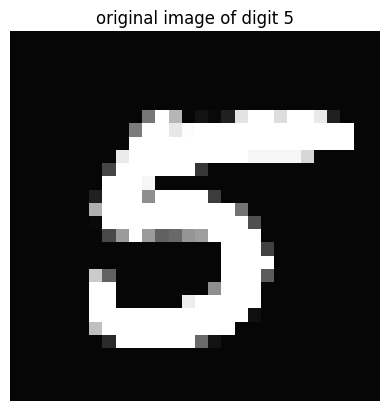

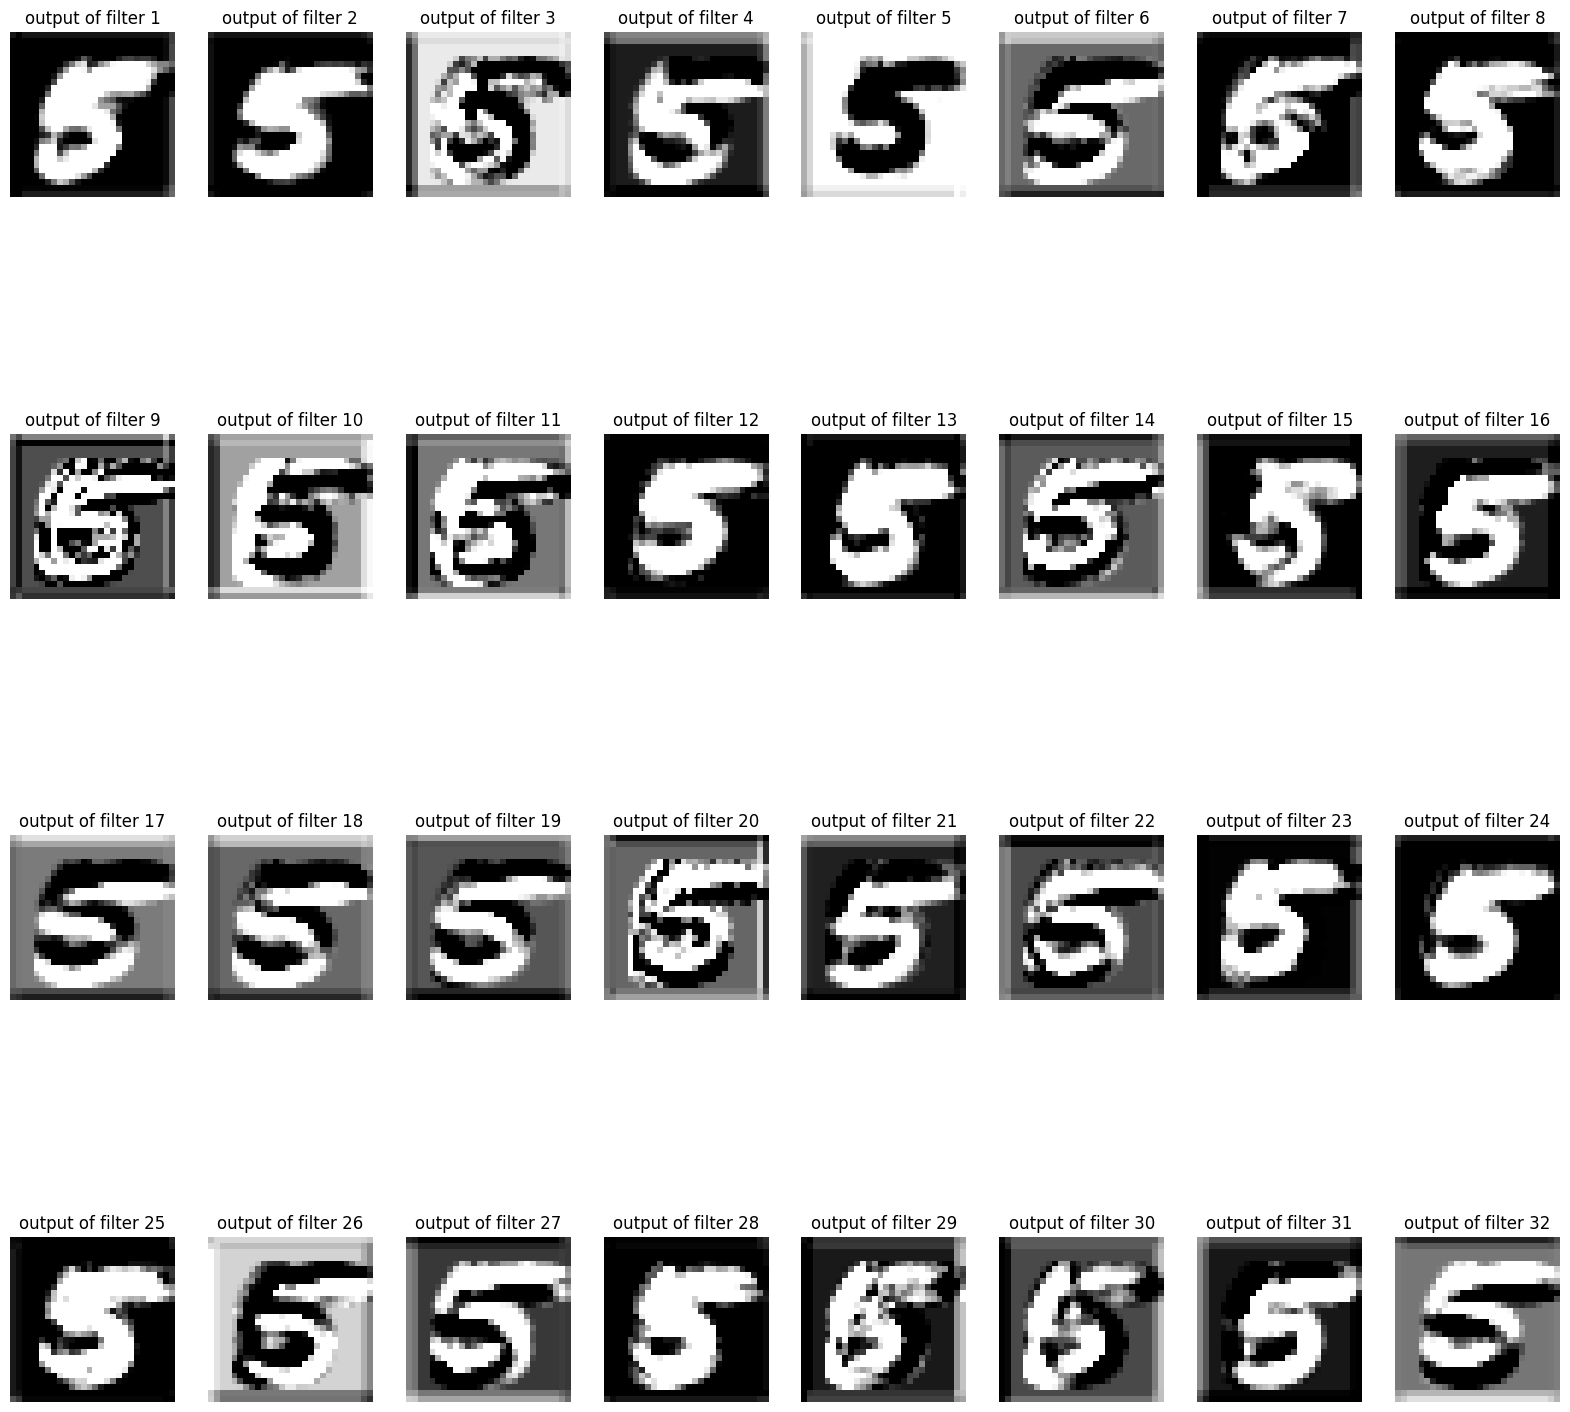

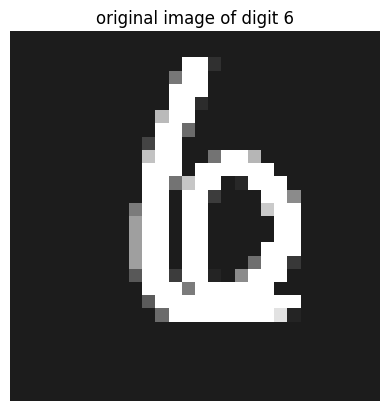

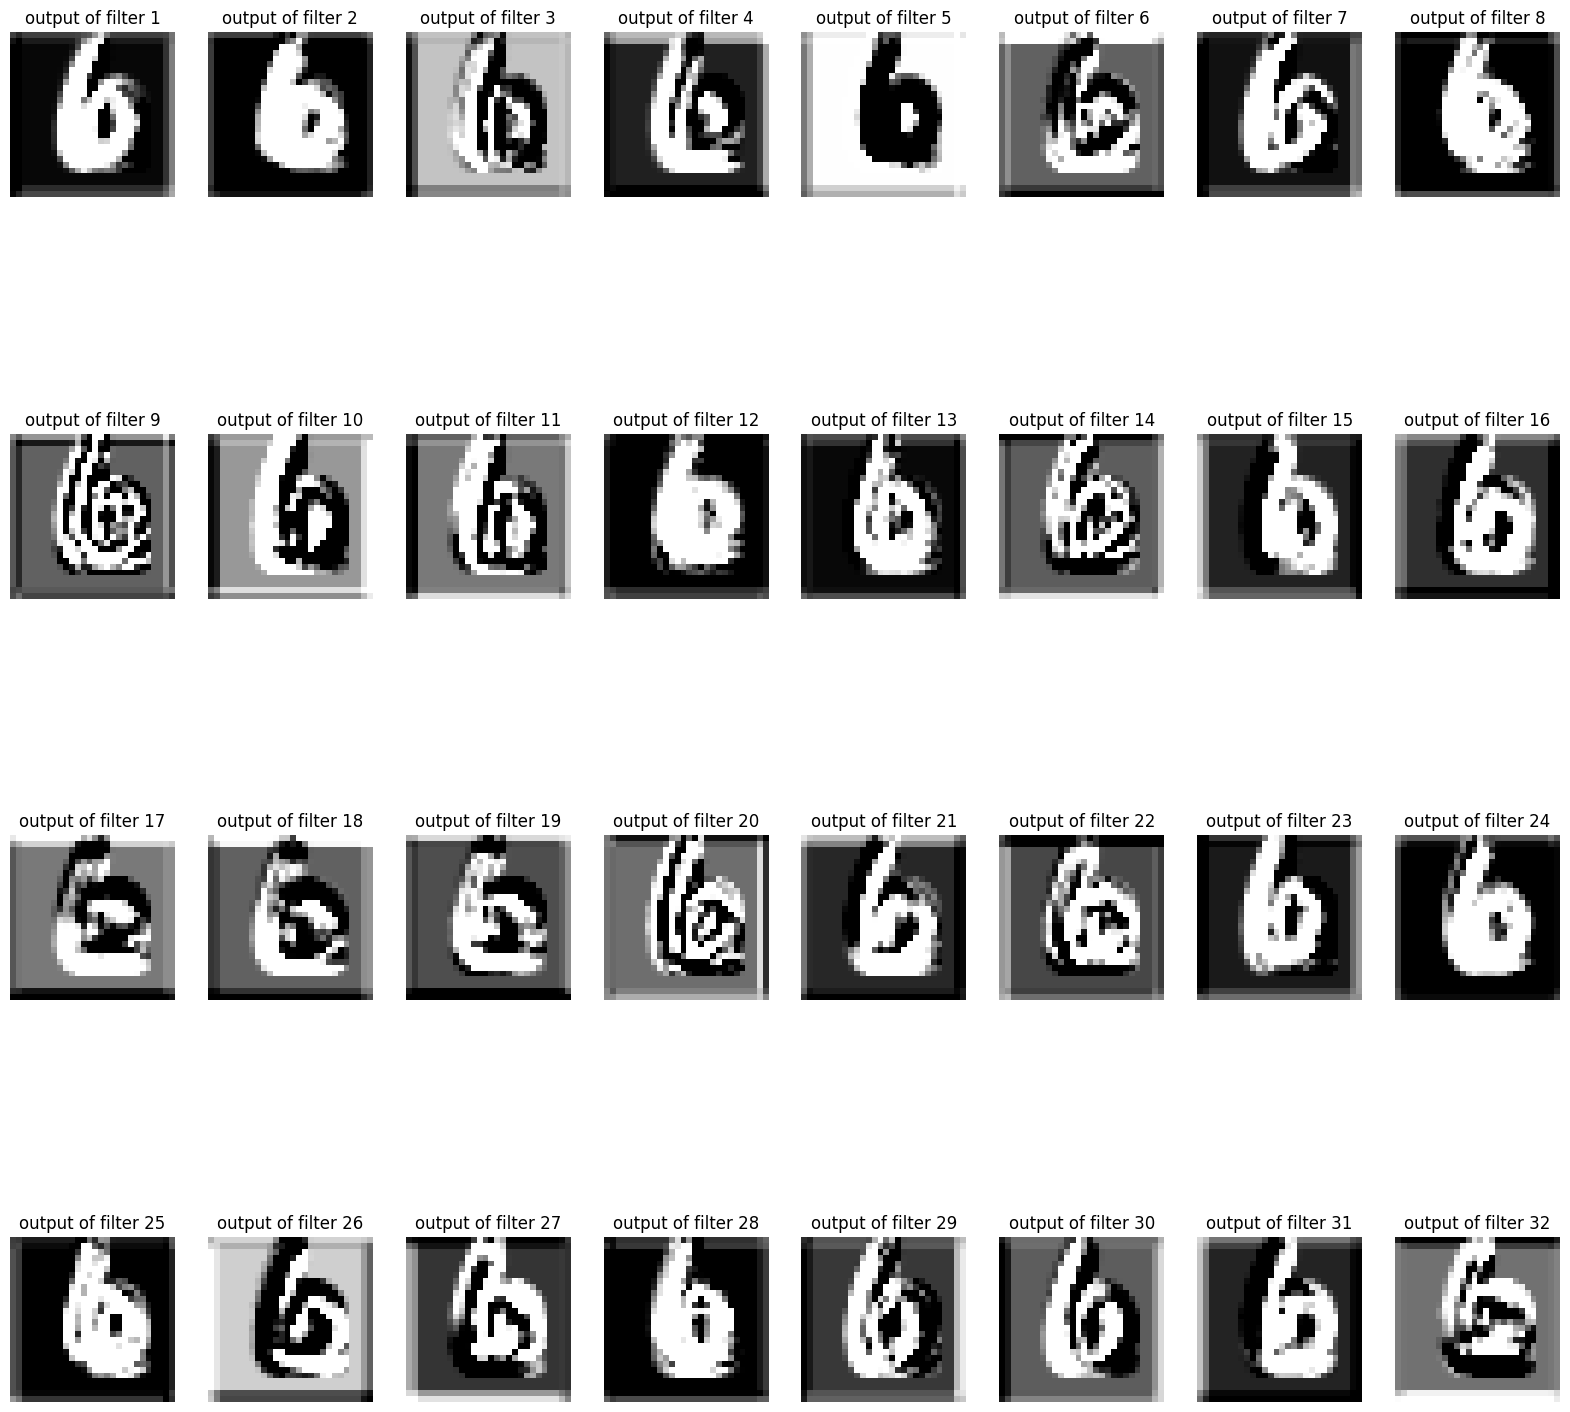

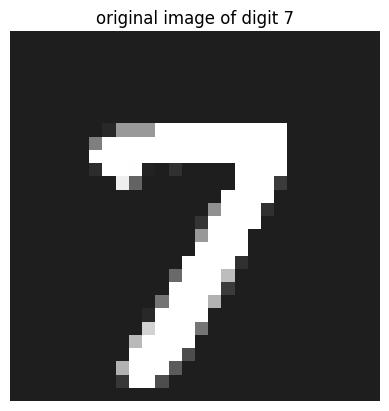

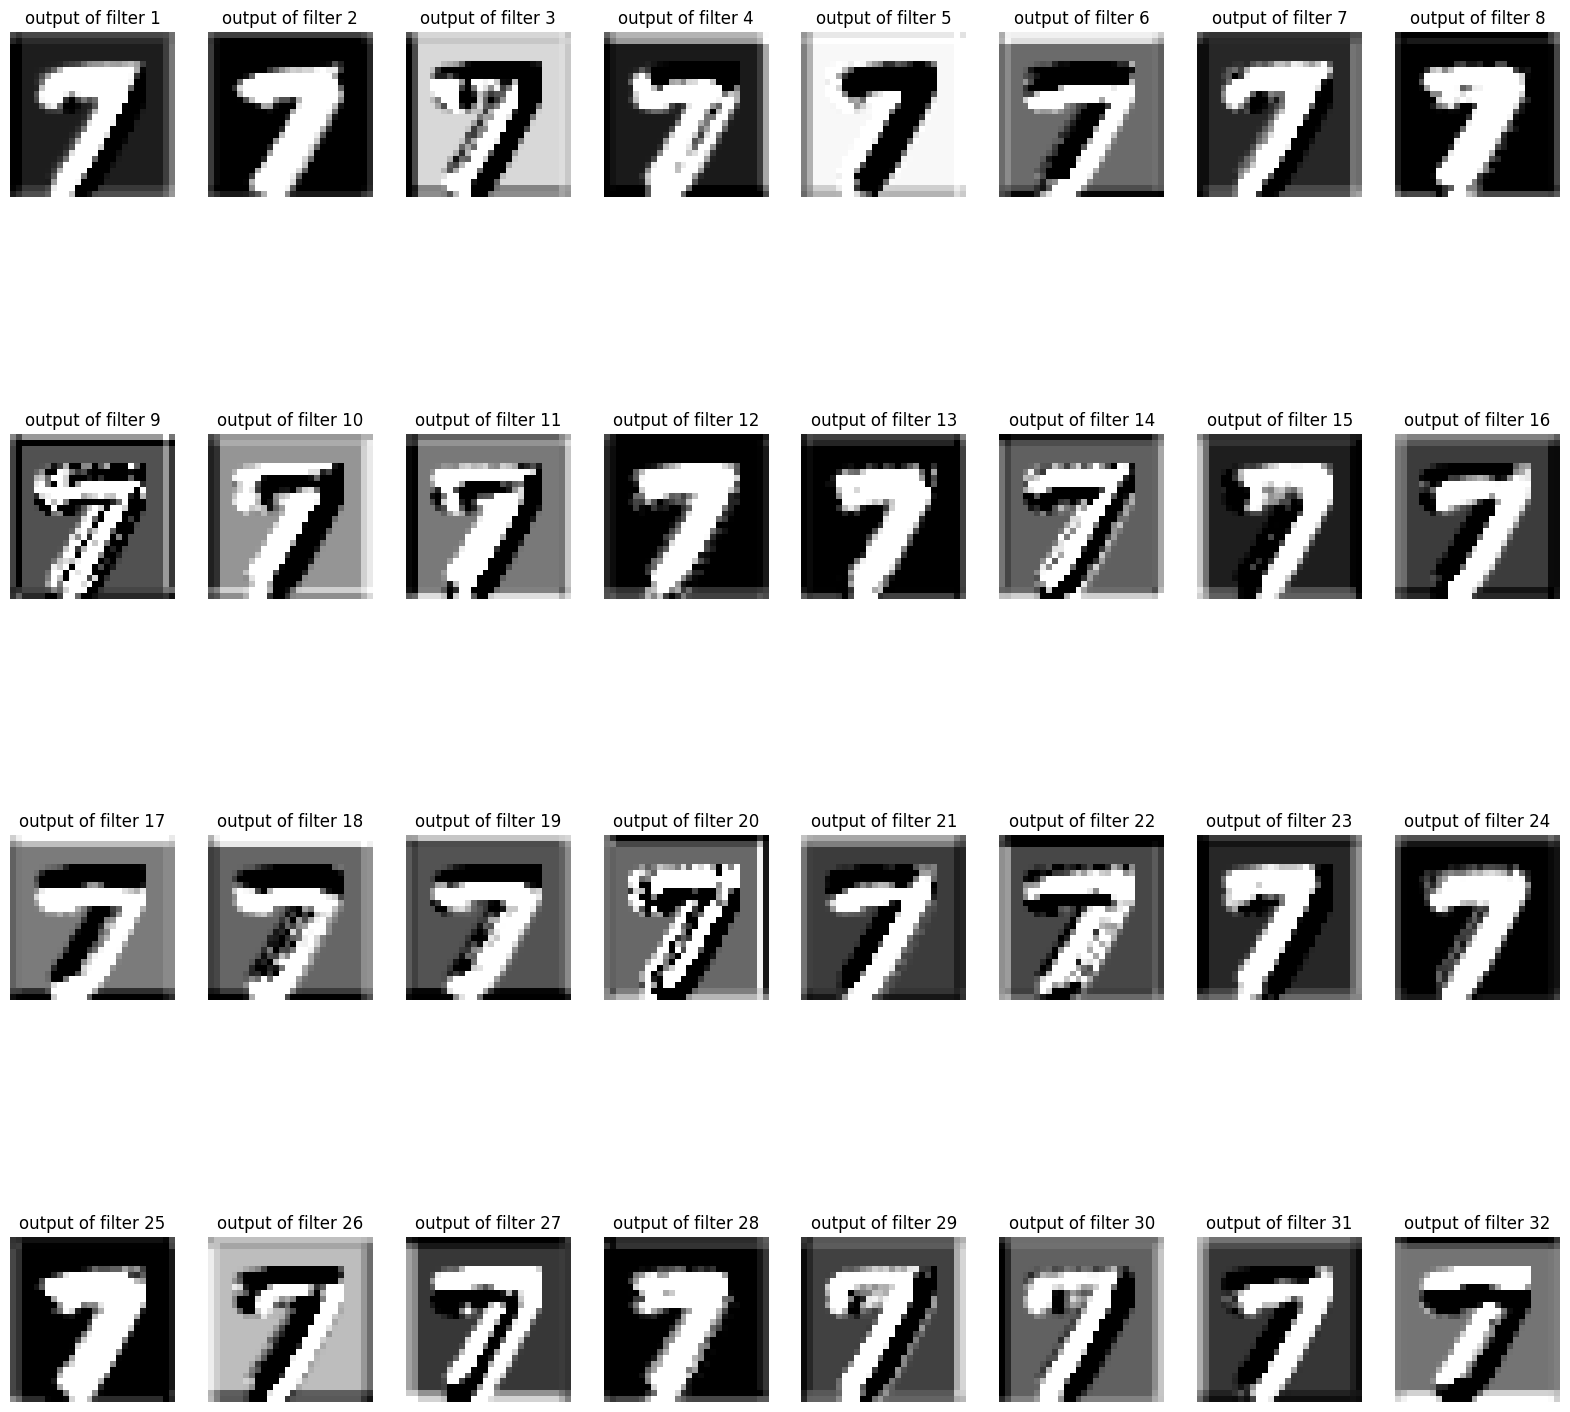

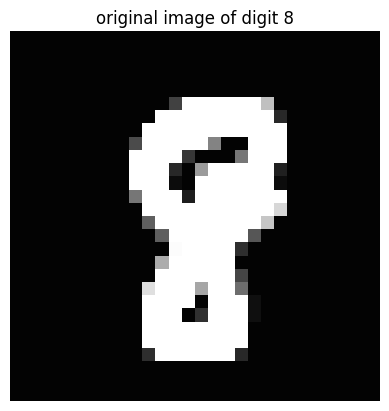

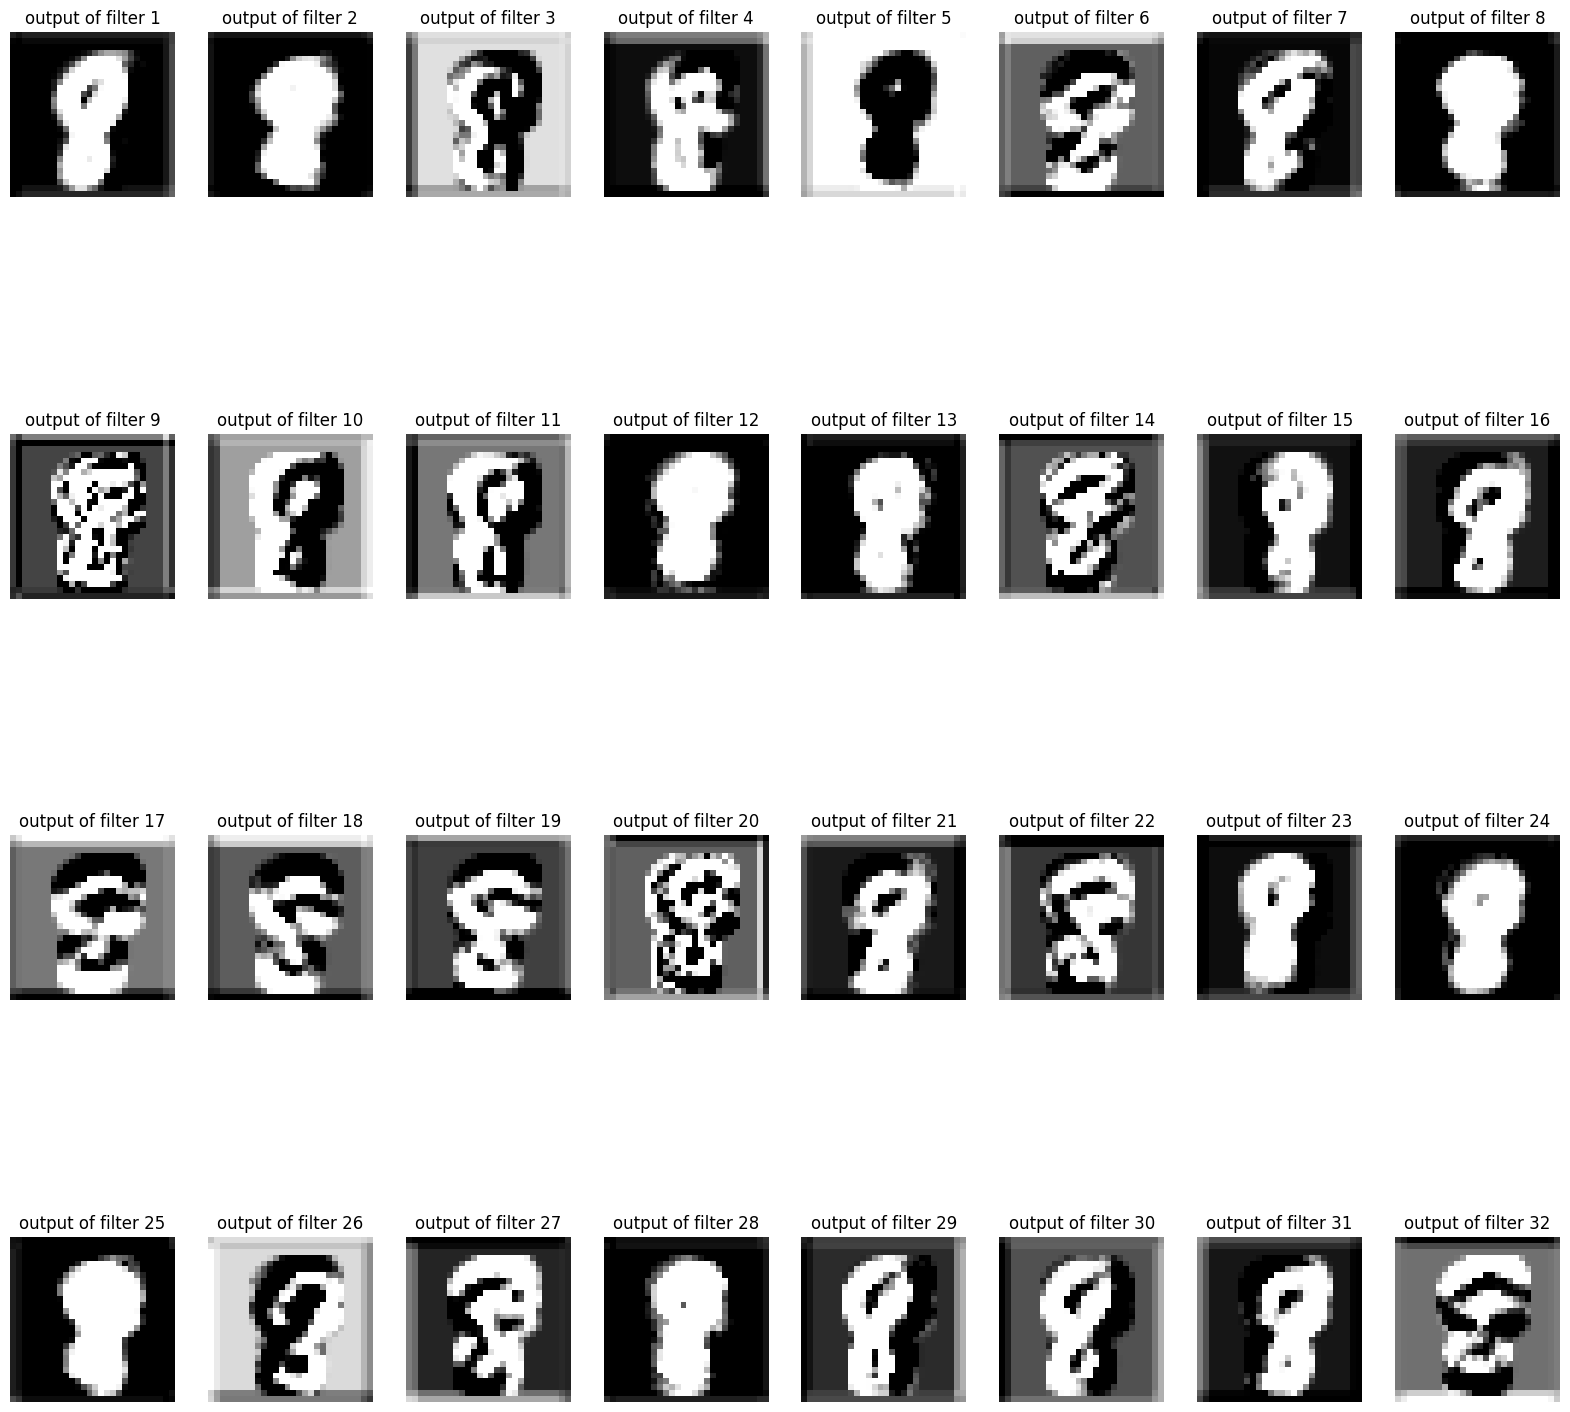

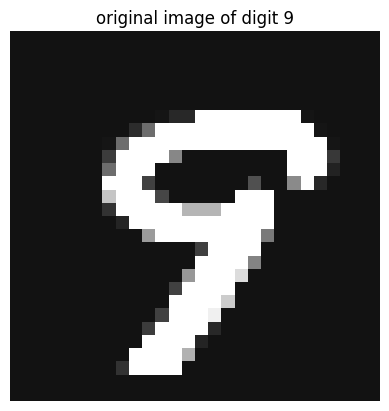

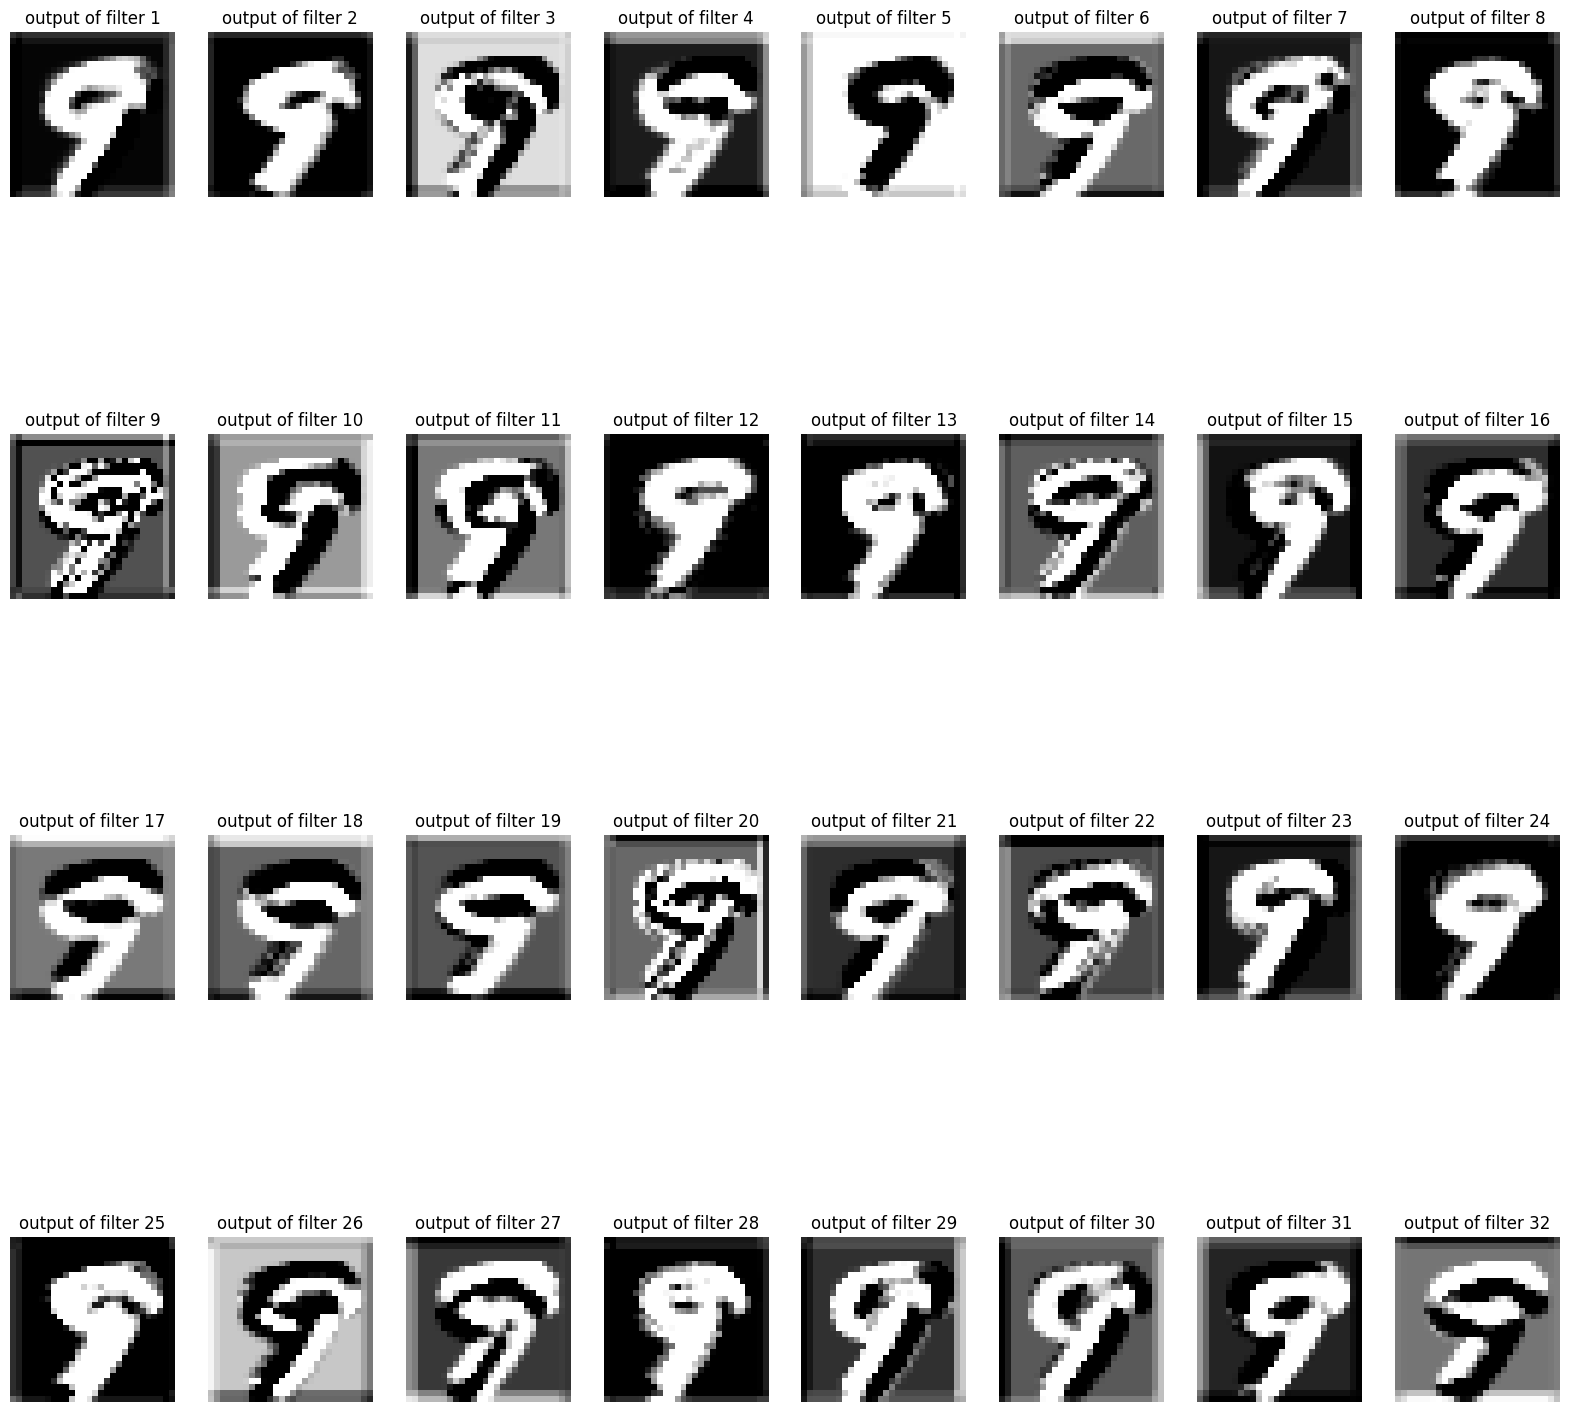

In [ ]:
### this code picks one sample from each label (each digit) for visualizing purposes
sample_digits = dict()
for data in train_loader:
    for i in range(data[1].shape[0]):
        if data[1][i].item() not in sample_digits.keys():
            sample_digits[data[1][i].item()]=data[0][i]
    if len(sample_digits.keys())==10:
        break

for digit in range(10):
    plt.figure()
    data = sample_digits[digit]
    npimg = data[0].numpy()
    npimg = normalize_image(npimg)
    plt.imshow(npimg,cmap="gray",vmin=0,vmax=1)
    plt.title("original image of digit %d"%digit)
    plt.axis("off")
    plt.figure(figsize=(20,20))
    
    with torch.no_grad():
        data = data.unsqueeze(0).to(device)
        ### ACT23
        ### data has shape (1,1,28,28)
        ### pass the data to only layer conv1 and apply RELU activation (do not apply maxpooling)
        ### the output should be a tensor of size (1,32,28,28)
        output = net.conv1(data)
    
    data_numpy = output.detach().cpu().numpy()
    for i in range(32):
        plt.subplot(4,8,i+1)
        npimg = data_numpy[0,i]
        npimg = normalize_image(npimg)
        plt.imshow(npimg,cmap="gray",vmin=0,vmax=1)
        plt.title("output of filter "+str(i+1))
        plt.axis("off")
    plt.show()
    
    ###ASSERTS
    assert(data.size()==(1,1,28,28))
    assert(output.size()==(1,32,28,28))

### Comparing with a Fully Connected Neural Network

Let's make a fully connected (FC) neural network with a similar number of parameters as your ConvNet. Then, we can compare the performance between the FC net and the ConvNet.

First, let's count the parameters in the ConvNet. The first convolutional layer has 32 5x5 filters, so 32\*5\*5 = 800 parameters.

The second convolutional layer has 64 5x5 filters, so 64\*5\*5 = 1600 parameters.

The first fully connected layer has an input of size 64\*x\*x = 64x^2. You already calculated x in ACT5, but here let's just estimate x as approximately 10, so we'll say the fully connected layer has an input of size 6400, and the output size is 512. So the first fully connected layer has around 6400\*512 = 3276800 parameters.

The last layer has input size 512 and output size 10, so it has 5120 parameters.

In total that is roughly 3276800 + 5120 + 800 + 1600 = 3284320 parameters.

----------------------------------------------------------

For a fully connected network, the input will have size 28 \* 28 = 784 and the output will have size 10. Let's use 3 hidden layers, with sizes 1500, 1000 and 500. Then the total number of parameters will be:

784\*1500 + 1500\*1000 + 1000\*500 + 500\*10 = 3181000 parameters, which is very similar to our ConvNet. Now let's compare the performance!

**ACT24**
**In 1-2 sentences explain why Fully Connected Layer performs better or worse than CNN.**

**ANSWER HERE:** The FC layer performs slightly worse, likely because of the fact that CNN is able to reuse parameters. And it can also utilize the structure of the images to its advantage.

In [ ]:
class FCNet(nn.Module):
    def __init__(self):
        super(FCNet, self).__init__()
        self.input_size = 28 * 28
        self.fc1 = nn.Linear(self.input_size, 1500)
        self.fc2 = nn.Linear(1500, 1000)
        self.fc3 = nn.Linear(1000, 500)
        self.fc4 = nn.Linear(500, 10)
    
    def forward(self, x):
        x = x.view(-1, self.input_size)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [ ]:
learning_rate = 0.01

net = FCNet()
a = net.to(device)
opt = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
loss_function = nn.CrossEntropyLoss()

trainer = Trainer(net=net,optim=opt,loss_function=loss_function, train_loader=train_loader)

losses = trainer.train(num_epochs)

epoch [1]: loss 0.693
epoch [2]: loss 0.202
epoch [3]: loss 0.135
epoch [4]: loss 0.100
epoch [5]: loss 0.076
epoch [6]: loss 0.058
epoch [7]: loss 0.046
epoch [8]: loss 0.035
epoch [9]: loss 0.028
epoch [10]: loss 0.022


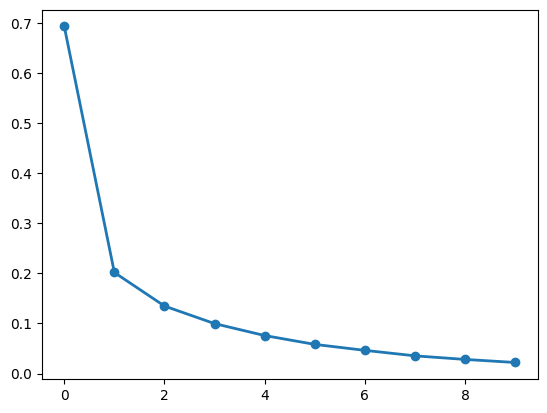

In [ ]:
plt.plot(losses, linewidth=2, linestyle='-', marker='o')

In [ ]:
err = 0
tot = 0
net.eval()
with torch.no_grad():
    for data in test_loader:
        # ACT18 retrieve X and y for this batch from data and 
        # move it to GPU (hint: look at what we did in trainer)
        X = data[0].to(device)
        y = data[1].to(device)

        # raw output of network for X
        output = net(X)
        
        # let the maximum index be our predicted class
        _, yh = torch.max(output, 1) 

        # tot will 10,000 at the end, total number of test data
        tot += y.size(0)

        ## ACT19 add to err number of missclassification, i.e. number of indices that 
        ## yh and y are not equal
        ## note that y and yh are vectors of size = batch_size = (256 in our case)
        err += not torch.equal(y, yh)

print('Accuracy of FC prediction on test digits: %5.2f%%' % (100-100 * err / tot))

Accuracy of FC prediction on test digits: 99.63%
